## Import libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data Preprocessing

### Load data and Redo the Processing that done in EDA

In [2]:
# Read the CSV file into a DataFrame(dfloan)
dfloan = pd.read_csv('../data/loan_data_2007_2014.csv', low_memory=False)

# Dropping unnecessary columns from the dataframe
dfloan = dfloan.drop(columns=['id', 'member_id', 'Unnamed: 0'], axis=1)

# Define a function to map loan status to 'Good Loan' or 'Bad Loan'
def map_loan_status(status):
    """
    Function to map loan status to 'Bad Loan' or 'Good Loan'.
    
    Parameters:
    status (str): The loan status to be mapped.
    
    Returns:
    str: 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise.
    """
    
    # List of loan statuses that imply a default
    default_statuses = [
        'Charged Off', 
        'Late (31-120 days)', 
        'Late (16-30 days)',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    
    # Return 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise
    return 'Bad Loan' if status in default_statuses else 'Good Loan'

# Apply the map_loan_status function to each status in the 'loan_status' column
dfloan['loan_status'] = dfloan['loan_status'].apply(map_loan_status)

# Convert the 'issue_d' column to datetime format with 'Oct-14' style dates
dfloan['issue_d'] = pd.to_datetime(dfloan['issue_d'], format='%b-%y')

# Extract the year from the datetime object ad store it in a new column 'years'
dfloan['years'] = dfloan['issue_d'].dt.year


# Define a list of state abbreviations that belong to the West region
West = [
    'CA',  # California
    'NV',  # Nevada
    'UT',  # Utah
    'CO',  # Colorado
    'WY',  # Wyoming
    'MT',  # Montana
    'ID',  # Idaho
    'OR',  # Oregon
    'WA',  # Washington
    'AK',  # Alaska
    'HI'   # Hawaii
]

# Define a list of state abbreviations that belong to the Southwest region
Southwest = [
    'AZ',  # Arizona
    'NM',  # New Mexico
    'TX',  # Texas
    'OK'   # Oklahoma
]

# Define a list of state abbreviations that belong to the Midwest region
Midwest = [
    'ND',  # North Dakota
    'MN',  # Minnesota
    'SD',  # South Dakota
    'NE',  # Nebraska
    'KS',  # Kansas
    'MO',  # Missouri
    'IA',  # Iowa
    'WI',  # Wisconsin
    'IL',  # Illinois
    'IN',  # Indiana
    'OH',  # Ohio
    'MI'   # Michigan
]

# Define a list of state abbreviations that belong to the Southeast region
Southeast = [
    'AR',  # Arkansas
    'LA',  # Louisiana
    'MS',  # Mississippi
    'AL',  # Alabama
    'GA',  # Georgia
    'TN',  # Tennessee
    'KY',  # Kentucky
    'NC',  # North Carolina
    'SC',  # South Carolina
    'WV',  # West Virginia
    'DC',  # District of Columbia
    'VA',  # Virginia
    'DE',  # Delaware
    'FL'   # Florida
]

# Define a list of state abbreviations that belong to the Northeast region
Northeast = [
    'PA',  # Pennsylvania
    'MD',  # Maryland
    'NJ',  # New Jersey
    'NY',  # New York
    'CT',  # Connecticut
    'RI',  # Rhode Island
    'MA',  # Massachusetts
    'NH',  # New Hampshire
    'VT',  # Vermont
    'ME'   # Maine
]

def us_region(state):
    """
    Function to map US state to its corresponding region.

    Parameters:
    state (str): The US state abbreviation.

    Returns:
    str: The region where the state is located.
    """
    # Check if the state is in the West region
    if state in West:
        return 'West'
    # Check if the state is in the Southwest region
    elif state in Southwest:
        return 'Southwest'
    # Check if the state is in the Midwest region
    elif state in Midwest:
        return 'Midwest'
    # Check if the state is in the Southeast region
    elif state in Southeast:
        return 'Southeast'
    # Check if the state is in the Northeast region
    elif state in Northeast:
        return 'Northeast'
    # If the state is not in any of the defined regions, return 'Other'
    else:
        return 'Other'

# Apply the function us_region to 'addr_state' column
# This will create a new column 'region' in the dataframe dfloan
dfloan['region'] = dfloan['addr_state'].apply(us_region)

### Drop Columns with High Missing Values

In [6]:
def dropnan(data, threshold):
    """
    Function to drop columns with missing values above a certain threshold.
    
    Parameters:
    data (DataFrame): The data to be cleaned.
    threshold (float): The threshold proportion of missing values, columns above threshold which will be dropped.
    
    Returns:
    DataFrame: The cleaned data with columns dropped based on the threshold.

    Examples:
    >>> dropnan(data, 0.5)
    """

    # Iterate over each column in the DataFrame
    for column in data.columns:
        
        # Calculate the proportion of missing values in the current column
        missing_values = data[column].isnull().sum() / len(data)

        # if the proportion of missing values is greatwer than the threshold
        if missing_values > threshold:
            
            # Drop the current column from the DataFrame
            data = data.drop(columns=column, axis=1)
    
    # Return the cleaned DataFrame
    return data

In [66]:
# Drop the columns with missing values above the threshold
dfloan_cleaned = dropnan(dfloan, 0.4)

print(dfloan.shape)
print(dfloan_cleaned.shape)

(466285, 74)
(466285, 52)


In [67]:
# potential_bin = ['delinq_2yrs', ]

### Drop Uneccessary Columns

In [35]:
not_necessary_col = ['sub_grade', 'emp_title', 'issue_d', 'pymnt_plan', 'url', 'zip_code', 'title', 'addr_state',
                     'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 'out_prncp_inv',
                     'total_pymnt_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_credit_pull_d',
                     'collections_12_mths_ex_med', 'application_type', 'policy_code', 'acc_now_delinq']
dfloan_cleaned1 = dfloan_cleaned.drop(columns=not_necessary_col, axis=1)

In [59]:
def plot_missing_value(data):
    # Calculate the percentage of missing values in each column
    missing = (data.isnull().sum() / len(data)) * 100
    
    # Filter out the columns that have no missing values
    missing = missing[missing>0]

    # Create a DataFrame from the missing data
    missing_data = pd.DataFrame({'Column': missing.index, 
                                 'Missing%': np.round(missing.values, 2)
    })

    # Sort the DataFrame by the percentage of missing values in descending order
    missing_data = missing_data.sort_values('Missing%', ascending=False)

    # Create a bar plot of the missing data
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x='Missing%', y='Column', data=missing_data, palette='viridis')

    # Add the percentage of missing data as text on the bars
    for i, v in enumerate(missing_data['Missing%']):
        ax.text(v + 0.5, i + .4, str(v) + '%', color='red')

    # Set the labels and title of the plot
    ax.set_xlabel('Missing Percentage')
    ax.set_title('Percentage Missing Data for each columns')


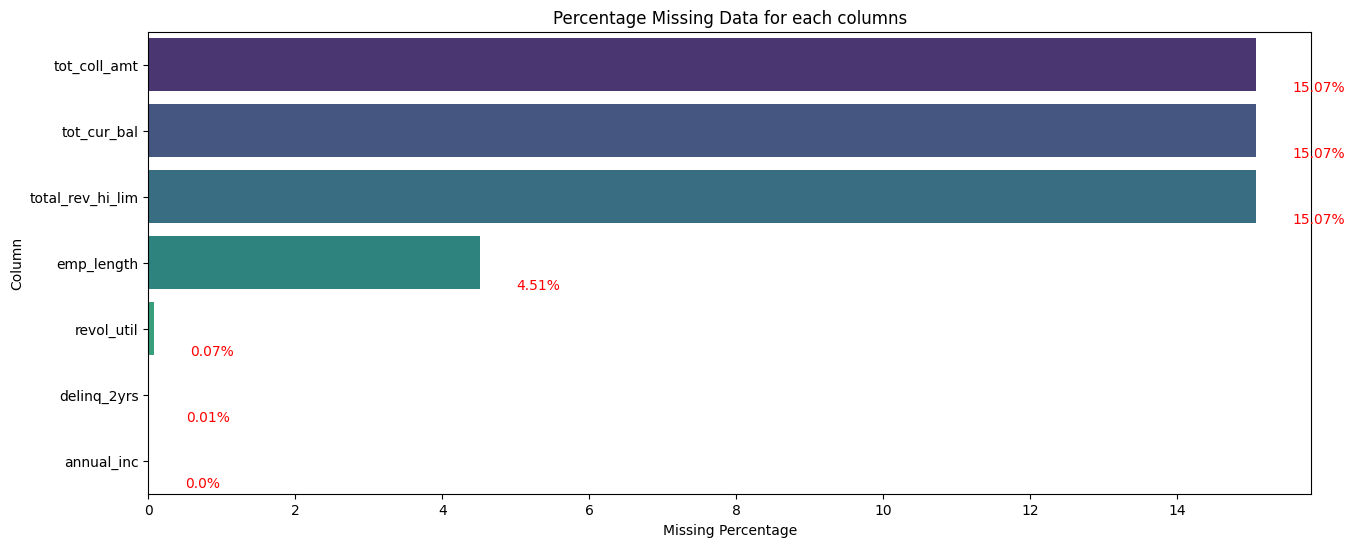

In [61]:
plot_missing_value(dfloan_cleaned1)

### Train Test Split

In [72]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1103)

print(f'X train shape: {X_train.shape}')
print(f'y train shape:{y_train.shape}')

print(f'\nX test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X train shape: (373028, 26)
y train shape:(373028,)

X test shape: (93257, 26)
y_test shape: (93257,)


### Impute rest of missing values

In [73]:
# define funtion to fill numerical missing values with median and categorical missing values with mode
def fillnan(data):
    """
    Function to fill missing values in a DataFrame. Numeric columns are filled with the median of the column,
    while categorical/non-numeric columns are filled with the mode.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.

    Returns:
    DataFrame: The cleaned DataFrame with missing values filled.

    Examples:
    >>> fillnan(data)

    """

    # Iterate over each column in the DataFrame
    for column in data.columns:

        # Check if the current column is numeric
        if data[column].dtype in ['int64', 'float64']:
            # Fill missing values with the median of the column
            data[column] = data[column].fillna(data[column].median())
        else:
            # Fill missing values with the mode of the column
            data[column] = data[column].fillna(data[column].mode()[0])
g
    # Return the cleaned DataFrame
    return data

# Fill missing values in the cleaned DataFrame
X_train_clean = fillnan(X_train)

Are we going to do WoE Transform first then do feature selection

In [ ]:
# X_test_clean = fillnan(X_test)